In [1]:
# Let's keep our notebook clean, so it's a little more readable!
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Machine learning to predict age from rs-fmri

The goal is to extract data from several rs-fmri images, and use that data as features in a machine learning model. We will integrate what we've learned in the previous machine learning lecture to build an unbiased model and test it on a left out sample.

Link to slides: https://figshare.com/s/4d9953055c9ed36301ad#/articles/9162428

## Load the data

<img src="Imgs/SampFeat.png" alt="terms" width="300"/>


In [3]:
# change this to the location where you downloaded the data
wdir = '/users/isabellesimard2/Documents/BrainHack_School_2019/osfstorage-archive/'


In [4]:
# Now fetch the data

from glob import glob
import os
data = sorted(glob(os.path.join(wdir,'*.gz')))
confounds = sorted(glob(os.path.join(wdir,'*regressors.tsv')))

How many individual subjects do we have?

In [5]:
#len(data.func)
len(data)

155

## Extract features

![feat_xtrct](https://ars.els-cdn.com/content/image/1-s2.0-S1053811919301594-gr1.jpg)

In order to do our machine learning, we will need to extract feature from our rs-fmri images.

Specifically, we will extract signals from a brain parcellation and compute a correlation matrix, representing regional coactivation between regions.

We will practice on one subject first, then we'll extract data for all subjects

#### Retrieve the atlas for extracting features and an example subject

Since we're using rs-fmri data, it makes sense to use an atlas defined using rs-fmri data

This paper has many excellent insights about what kind of atlas to use for an rs-fmri machine learning task. See in particular Figure 5.

https://www.sciencedirect.com/science/article/pii/S1053811919301594?via%3Dihub

Let's use the MIST atlas, created here in Montreal using the BASC method. This atlas has multiple resolutions, for larger networks or finer-grained ROIs. Let's use a 64-ROI atlas to allow some detail, but to ultimately keep our connectivity matrices manageable

Here is a link to the MIST paper: https://mniopenresearch.org/articles/1-3

In [6]:
from nilearn import datasets

parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064


print('Atlas ROIs are located in nifti image (4D) at: %s' %
       atlas_filename)

/Users/isabellesimard2/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Atlas ROIs are located in nifti image (4D) at: /Users/isabellesimard2/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


Let's have a look at that atlas

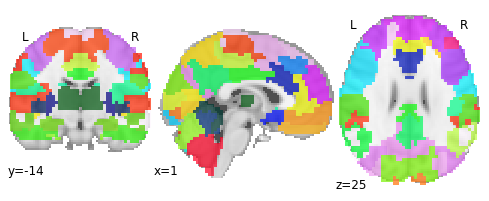

In [7]:
from nilearn import plotting

plotting.plot_roi(atlas_filename, draw_cross=False)

Great, let's load an example 4D fmri time-series for one subject

In [8]:
fmri_filenames = data[0]
print(fmri_filenames)

/users/isabellesimard2/Documents/BrainHack_School_2019/osfstorage-archive/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


Let's have a look at the image! Because it is a 4D image, we can only look at one slice at a time. Or, better yet, let's look at an average image!

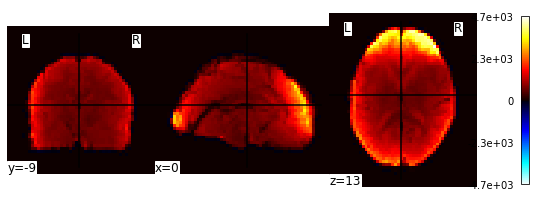

In [9]:
from nilearn import image 

averaged_Img = image.mean_img(image.mean_img(fmri_filenames))
plotting.plot_stat_map(averaged_Img)

#### Extract signals on a parcellation defined by labels
Using the NiftiLabelsMasker

So we've loaded our atlas and 4D data for a single subject. Let's practice extracting features!


In [10]:
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=1)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
conf = confounds[0]
time_series = masker.fit_transform(fmri_filenames, confounds=conf)

[NiftiLabelsMasker.fit_transform] loading data from /Users/isabellesimard2/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
Resampling labels


So what did we just create here?

In [11]:
type(time_series)

numpy.ndarray

In [12]:
time_series.shape
#time_series.mean(0).shape
#to compute mean activity 

(168, 64)

What are these "confounds" and how are they used? 

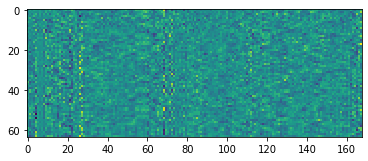

In [13]:
import matplotlib.pyplot as plt
plt.imshow(time_series.T)





In [14]:
import pandas
conf_df = pandas.read_table(conf)
conf_df.head()

,csf,white_matter,global_signal,std_dvars,dvars,framewise_displacement,t_comp_cor_00,t_comp_cor_01,t_comp_cor_02,t_comp_cor_03,...,cosine00,cosine01,cosine02,cosine03,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,818.550141,875.069943,1262.020140,0.000000,0.000000,0.000000,-0.020679,-0.033857,0.095524,-0.022131,...,0.109104,0.109090,0.109066,0.109033,0.013422,-0.235811,0.033243,-0.000900,-9.976860e-24,0.000152
1,815.643544,873.886244,1260.829698,1.320145,37.240650,0.124271,-0.007043,-0.045004,-0.032265,-0.000439,...,0.109066,0.108937,0.108723,0.108423,0.030943,-0.238651,0.088048,-0.001747,-1.329770e-04,0.000154
2,820.769909,872.997093,1262.678653,1.299640,36.662231,0.052546,-0.005027,-0.089152,-0.052859,-0.083313,...,0.108990,0.108632,0.108038,0.107207,0.012759,-0.230284,0.097429,-0.001644,-0.000000e+00,0.000250
3,816.815767,872.913170,1261.592396,1.540568,43.458698,0.100117,0.053507,-0.081439,0.029216,-0.002027,...,0.108875,0.108176,0.107012,0.105391,0.010014,-0.213517,0.143186,-0.001455,9.294130e-05,0.000665
4,818.287589,872.019839,1249.983704,2.743071,77.380722,0.272004,0.025015,-0.061691,0.023856,-0.159531,...,0.108723,0.107567,0.105651,0.102986,0.059444,-0.259451,0.083982,-0.000378,3.686370e-04,0.001661


In [15]:
conf_df.shape

(168, 28)

#### Compute and display a correlation matrix


In [16]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
correlation_matrix.shape

(64, 64)

Plot the correlation matrix

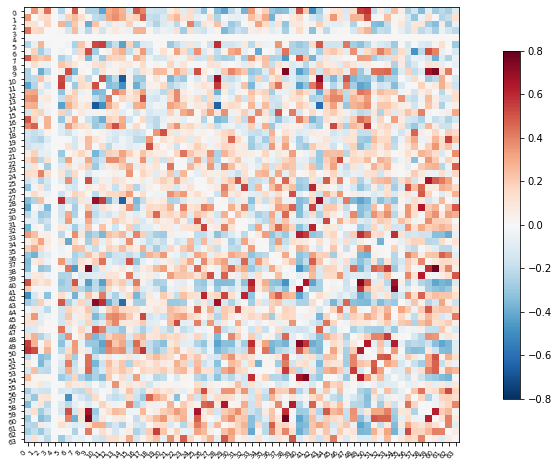

In [17]:
import numpy as np
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

# The labels we have start with the background (0), hence we skip the
# first label
plotting.plot_matrix(correlation_matrix, figure=(10, 8), 
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

# matrices are ordered for block-like representation

#### Extract features from the whole dataset

Here, we are going to use a for loop to iterate through each image and use the same techniques we learned above to extract rs-fmri connectivity features from every subject.



In [18]:
# Here is a really simple for loop

for i in range(10):
    print('the number is', i)

the number is 0
the number is 1
the number is 2
the number is 3
the number is 4
the number is 5
the number is 6
the number is 7
the number is 8
the number is 9


In [19]:
container = []
for i in range(10):
    container.append(i)

container

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Now lets construct a more complicated loop to do what we want

First we do some things we don't need to do in the loop. Let's reload our atlas, and re-initiate our masker and correlation_measure

In [20]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets

# load atlas
multiscale = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = multiscale.scale064

# initialize masker (change verbosity)
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# initialize correlation measure, set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

Okay -- now that we have that taken care of, let's run our big loop!

**NOTE**: On a laptop, this might a few minutes.

In [23]:
all_features_FNC = [] # here is where we will put the data (a container)

all_features_Neural_Activity = []

for i,sub in enumerate(data):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub, confounds=confounds[i])
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    flattened_TA = time_series.flatten ()
    # add to our container
    all_features_FNC.append(correlation_matrix)
    all_features_Neural_Activity.append(flattened_TA)
    # keep track of status
    print('finished %s of %s'%(i+1,len(data)))

finished 1 of 155
finished 2 of 155
finished 3 of 155
finished 4 of 155
finished 5 of 155
finished 6 of 155
finished 7 of 155
finished 8 of 155
finished 9 of 155
finished 10 of 155
finished 11 of 155
finished 12 of 155
finished 13 of 155
finished 14 of 155
finished 15 of 155
finished 16 of 155
finished 17 of 155
finished 18 of 155
finished 19 of 155
finished 20 of 155
finished 21 of 155
finished 22 of 155
finished 23 of 155
finished 24 of 155
finished 25 of 155
finished 26 of 155
finished 27 of 155
finished 28 of 155
finished 29 of 155
finished 30 of 155
finished 31 of 155
finished 32 of 155
finished 33 of 155
finished 34 of 155
finished 35 of 155
finished 36 of 155
finished 37 of 155
finished 38 of 155
finished 39 of 155
finished 40 of 155
finished 41 of 155
finished 42 of 155
finished 43 of 155
finished 44 of 155
finished 45 of 155
finished 46 of 155
finished 47 of 155
finished 48 of 155
finished 49 of 155
finished 50 of 155
finished 51 of 155
finished 52 of 155
finished 53 of 155
fi

In [24]:
# Let's save the data to disk
import numpy as np

np.savez_compressed('MAIN_BASC064_subsamp_features_Combined_Metrics',a = all_features_FNC, b = all_features_Neural_Activity)

In case you do not want to run the full loop on your computer, you can load the output of the loop here!

In [28]:
feat_file = 'MAIN_BASC064_subsamp_features_Combined_Metrics.npz'
X_features_FNC = np.load(feat_file)['a','b']

TypeError: not all arguments converted during string formatting

In [ ]:
X_features_FNC.shape

<img src="Imgs/SampFeat.png" alt="terms" width="300"/>

Okay so we've got our features.

We can visualize our feature matrix

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X_features_FNC, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

## Get Y (our target) and assess its distribution

In [ ]:
# Let's load the phenotype data

pheno_path = os.path.join(wdir, 'participants.tsv')

In [ ]:
import pandas

pheno = pandas.read_csv(pheno_path, sep='\t').sort_values('participant_id')
pheno.head()

Looks like there is a column labeling age. Let's capture it in a variable

In [ ]:
y_age = pheno['Age']

Maybe we should have a look at the distribution of our target variable

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(y_age)

## Prepare data for machine learning

Here, we will define a "training sample" where we can play around with our models. We will also set aside a "validation" sample that we will not touch until the end

We want to be sure that our training and test sample are matched! We can do that with a "stratified split". This dataset has a variable indicating AgeGroup. We can use that to make sure our training and testing sets are balanced!

In [ ]:
age_class = pheno['AgeGroup']
age_class.value_counts()

In [ ]:
from sklearn.model_selection import train_test_split

# Split the sample to training/validation with a 60/40 ratio, and 
# stratify by age class, and also shuffle the data.

X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features_FNC, # x
                                                    y_age, # y
                                                    test_size = 0.4, # 60%/40% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

Let's visualize the distributions to be sure they are matched

In [ ]:
sns.distplot(y_train)
sns.distplot(y_val)

## Run your first model!

Machine learning can get pretty fancy pretty quickly. We'll start with a fairly standard regression model called a Support Vector Regressor (SVR). 

While this may seem unambitious, simple models can be very robust. And we probably don't have enough data to create more complex models (but we can try later).

For more information, see this excellent resource:
https://hal.inria.fr/hal-01824205

Let's fit our first model!

In [ ]:
from sklearn.svm import SVR
l_svr = SVR(kernel='linear') # define the model

l_svr.fit(X_train, y_train) # fit the model

Well... that was easy. Let's see how well the model learned the data!


<img src="Imgs/modval.png" alt="terms" width="800"/>

In [ ]:

# predict the training data based on the model
y_pred = l_svr.predict(X_train) 

# caluclate the model accuracy
acc = l_svr.score(X_train, y_train) 


Let's view our results and plot them all at once!

In [ ]:
# print results
print('accuracy (R2)', acc)

sns.regplot(y_pred,y_train)
plt.xlabel('Predicted Age')

HOLY COW! Machine learning is amazing!!! Almost a perfect fit!

...which means there's something wrong. What's the problem here?

In [ ]:
from sklearn.model_selection import train_test_split

# Split the sample to training/test with a 75/25 ratio, and 
# stratify by age class, and also shuffle the data.

age_class2 = pheno.loc[y_train.index,'AgeGroup']

X_train2, X_test, y_train2, y_test = train_test_split(
                                                    X_train, # x
                                                    y_train, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class2,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train2),
     'testing:', len(X_test))

In [ ]:
from sklearn.metrics import mean_absolute_error

# fit model just to training data
l_svr.fit(X_train2,y_train2)

# predict the *test* data based on the model trained on X_train2
y_pred = l_svr.predict(X_test) 

# caluclate the model accuracy
acc = l_svr.score(X_test, y_test) 
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)

In [ ]:
# print results
print('accuracy (R2) = ', acc)
print('MAE = ',mae)

sns.regplot(y_pred,y_test)
plt.xlabel('Predicted Age')

Not perfect, but as predicting with unseen data goes, not too bad! Especially with a training sample of "only" 69 subjects. But we can do better! 

For example, we can increase the size our training set while simultaneously reducing bias by instead using 10-fold cross-validation

<img src="Imgs/KCV.png" alt="terms" width="500"/>

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score

# predict
y_pred = cross_val_predict(l_svr, X_train, y_train, cv=10)
# scores
acc = cross_val_score(l_svr, X_train, y_train, cv=10)
mae = cross_val_score(l_svr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

We can look at the accuracy of the predictions for each fold of the cross-validation

In [ ]:
for i in range(10):
    print('Fold {} -- Acc = {}, MAE = {}'.format(i, acc[i],-mae[i]))

We can also look at the overall accuracy of the model

In [ ]:
from sklearn.metrics import r2_score

overall_acc = r2_score(y_train, y_pred)
overall_mae = mean_absolute_error(y_train,y_pred)
print('R2:',overall_acc)
print('MAE:',overall_mae)

sns.regplot(y_pred, y_train)
plt.xlabel('Predicted Age')

Not too bad at all! But more importantly, this is a more accurate estimation of our model's predictive efficacy. Our sample size is larger and this is based on several rounds of prediction of unseen data. 

For example, we can now see that the effect is being driven by the model's successful parsing of adults vs. children, but is not performing so well within the adult or children group. This was not evident during our previous iteration of the model

## Tweak your model

It's very important to learn when and where its appropriate to "tweak" your model.

Since we have done all of the previous analysis in our training data, it's fine to try out different models. But we **absolutely cannot** "test" it on our left out data. If we do, we are in great danger of overfitting.

It is not uncommon to try other models, or tweak hyperparameters. In this case, due to our relatively small sample size, we are probably not powered sufficiently to do so, and we would once again risk overfitting. However, for the sake of demonstration, we will do some tweaking. 

<img src="Imgs/KCV2.png" alt="terms" width="500"/>


We will try a few different examples:
* Normalizing our target data
* Tweaking our hyperparameters
* Trying a more complicated model
* Feature selection

#### Normalize the target data

In [ ]:
# Create a log transformer function and log transform Y (age)

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(func = np.log, validate=True)
log_transformer.fit(y_train.values.reshape(-1,1))
y_train_log = log_transformer.transform(y_train.values.reshape(-1,1))[:,0]

sns.distplot(y_train_log)
plt.title("Log-Transformed Age")

Now let's go ahead and cross-validate our model once again with this new log-transformed target

In [ ]:
# predict
y_pred = cross_val_predict(l_svr, X_train, y_train_log, cv=10)

# scores
acc = r2_score(y_train_log, y_pred)
mae = mean_absolute_error(y_train_log,y_pred)

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred, y_train_log)
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.savefig('FNC_Train_Model_Log_Age.png')

Seems like a definite improvement, right? I think we can agree on that. 

But we can't forget about interpretability? The MAE is much less interpretable now.

#### Tweak the hyperparameters

Many machine learning algorithms have hyperparameters that can be "tuned" to optimize model fitting. Careful parameter tuning can really improve a model, but haphazard tuning will often lead to overfitting.

Our SVR model has multiple hyperparameters. Let's explore some approaches for tuning them

In [ ]:
SVR?

One way is to plot a "Validation Curve" -- this will let us view changes in training and validation accuracy of a model as we shift its hyperparameters. We can do this easily with sklearn.

In [ ]:
from sklearn.model_selection import validation_curve

C_range = 10. ** np.arange(-3, 8) # A range of different values for C

train_scores, valid_scores = validation_curve(l_svr, X_train, y_train_log, 
                                              param_name= "C",
                                              param_range = C_range,
                                              cv=10)


In [ ]:
# A bit of pandas magic to prepare the data for a seaborn plot

tScores = pandas.DataFrame(train_scores).stack().reset_index()
tScores.columns = ['C','Fold','Score']
tScores.loc[:,'Type'] = ['Train' for x in range(len(tScores))]

vScores = pandas.DataFrame(valid_scores).stack().reset_index()
vScores.columns = ['C','Fold','Score']
vScores.loc[:,'Type'] = ['Validate' for x in range(len(vScores))]

ValCurves = pandas.concat([tScores,vScores]).reset_index(drop=True)
ValCurves.head()

In [ ]:
# And plot!
g = sns.lineplot(x='C',y='Score',hue='Type',data=ValCurves)
g.set_xticks(range(10))
g.set_xticklabels(C_range, rotation=90)

# g = sns.factorplot(x='C',y='Score',hue='Type',data=ValCurves)
# plt.xticks(range(10))
# g.set_xticklabels(C_range, rotation=90)

It looks like accuracy is better for higher values of C, and plateaus somewhere between 0.1 and 1. The default setting is C=1, so it looks like we can't really improve by changing C.

But our SVR model actually has two hyperparameters, C and epsilon. Perhaps there is an optimal combination of settings for these two parameters.

We can explore that somewhat quickly with a grid search, which is once again easily achieved with sklearn. Because we are fitting the model multiple times witih cross-validation, this will take some time

In [ ]:
from sklearn.model_selection import GridSearchCV

C_range = 10. ** np.arange(-3, 8)
epsilon_range = 10. ** np.arange(-3, 8)

param_grid = dict(epsilon=epsilon_range, C=C_range)

grid = GridSearchCV(l_svr, param_grid=param_grid, cv=10)

grid.fit(X_train, y_train_log)

Now that the grid search has completed, let's find out what was the "best" parameter combination

In [ ]:
print(grid.best_params_)

And if redo our cross-validation with this parameter set?

In [ ]:
y_pred = cross_val_predict(SVR(kernel='linear',C=0.10,epsilon=0.10, gamma='auto'), 
                           X_train, y_train_log, cv=10)

# scores
acc = r2_score(y_train_log, y_pred)
mae = mean_absolute_error(y_train_log,y_pred)

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred, y_train_log)
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

Perhaps unsurprisingly, the model fit is actually exactly the same as what we had with our defaults. There's a reason they are defaults ;-)

Grid search can be a powerful and useful tool. But can you think of a way that, if not properly utilized, it could lead to overfitting?

You can find a nice set of tutorials with links to very helpful content regarding how to tune hyperparameters and while be aware of over- and under-fitting here:

https://scikit-learn.org/stable/modules/learning_curve.html

#### Trying a more complicated model

In principle, there is no real reason to do this. Perhaps one could make an argument for quadratic relationship with age, but we probably don't have enough subjects to learn a complicated non-linear model. But for the sake of demonstration, we can give it a shot.

We'll use a validation curve to see the result of our model if, instead of fitting a linear model, we instead try to the fit a 2nd, 3rd, ... 8th order polynomial.

In [ ]:
validation_curve?

In [ ]:
from sklearn.model_selection import validation_curve

degree_range = list(range(1,8)) # A range of different values for C

#Every range is a different type of polynomial

train_scores, valid_scores = validation_curve(SVR(kernel='poly',
                                                  gamma='scale'
                                                 ), 
                                              X=X_train, y=y_train_log, 
                                              param_name= "degree",
                                              param_range = degree_range,
                                              cv=10)


In [ ]:
# A bit of pandas magic to prepare the data for a seaborn plot

tScores = pandas.DataFrame(train_scores).stack().reset_index()
tScores.columns = ['Degree','Fold','Score']
tScores.loc[:,'Type'] = ['Train' for x in range(len(tScores))]

vScores = pandas.DataFrame(valid_scores).stack().reset_index()
vScores.columns = ['Degree','Fold','Score']
vScores.loc[:,'Type'] = ['Validate' for x in range(len(vScores))]

ValCurves = pandas.concat([tScores,vScores]).reset_index(drop=True)
ValCurves.head()

In [ ]:
# And plot!

g = sns.lineplot(x='Degree',y='Score',hue='Type',data=ValCurves)
g.set_xticks(range(10))
g.set_xticklabels(degree_range, rotation=90)

# g = sns.factorplot(x='Degree',y='Score',hue='Type',data=ValCurves)
# plt.xticks(range(10))
# g.set_xticklabels(degree_range, rotation=90)

It appears that we cannot improve our model by increasing the complexity of the fit. If one looked only at the training data, one might surmise that a 2nd order fit could be a slightly better model. But that improvement does not generalize to the validation data.

In [ ]:
# y_pred = cross_val_predict(SVR(kernel='rbf', gamma='scale'), X_train, y_train_log, cv=10)

# # scores
# acc = r2_score(y_train_log, y_pred)
# mae = mean_absolute_error(y_train_log,y_pred)

# print('R2:',acc)
# print('MAE:',mae)

# sns.regplot(y_pred, y_train_log)
# plt.xlabel('Predicted Log Age')
# plt.ylabel('Log Age')

#### Feature selection

Right now, we have 2016 features. Are all of those really going to contribute to the model stably? 

Intuitively, models tend to perform better when there are fewer, more important features than when there are many, less imortant features. The tough part is figuring out which features are useful or important.

Here will quickly try a basic feature seclection strategy

<img src="Imgs/FeatSel.png" alt="terms" width="400"/>

The SelectPercentile() function will select the top X% of features based on univariate tests. This is a way of identifying theoretically more useful features. But remember, significance != prediction! 

We are also in danger of overfitting here. For starters, if we want to test this with 10-fold cross-validation, we will need to do a separate feature selection within each fold! That means we'll need to do the cross-validation manually instead of using cross_val_predict(). 

### PCA Feature Reduction
Establishing the number of components to use in the model by plotting the results of the PCA.

Since I have a lot of features, I want to test if reducing the number of feartures using a PCA analysis would improve the model. First, I run an ICA analysis to see how many components explain 100% of the variance and how much variance is explained by each feature.

In [ ]:
from sklearn.decomposition import PCA
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_features_FNC)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
ax = plt.figure().add_subplot(1, 1, 1)
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 161, 20)
minor_ticks = np.arange(0, 161, 5)


ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='both')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

Next, I run a predictive model that pipelines the PCA and the SVR on each fold of the cross-validation.

In [ ]:
#from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

# Build a tiny pipeline that does dimension reduction using a PCA algorithm, 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',PCA(random_state=123)),
    ('prediction', l_svr)
                 ])

y_pred = [] # a container to catch the predictions from each fold
y_index = [] # just in case, the index for each prediciton

# First we create 10 splits of the data
skf = KFold(n_splits=10, shuffle=True, random_state=123)

# For each split, assemble the train and test samples 
for tr_ind, te_ind in skf.split(X_train):
    X_tr = X_train[tr_ind]
    y_tr = y_train_log[tr_ind]
    X_te = X_train[te_ind]
    y_index += list(te_ind) # store the index of samples to predict
    
    # and run our pipeline 
    model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
    predictions = model.predict(X_te).tolist() # get the predictions for this fold
    y_pred += predictions # add them to the list of predictions


    

Alrighty, let's see if only using the PCA dimension reduction improves the model at all...

In [ ]:
acc = r2_score(y_train_log[y_index], y_pred)
mae = mean_absolute_error(y_train_log[y_index],y_pred)

print('R2:',acc)
print('MAE:',mae)

sns.regplot(np.array(y_pred), y_train_log[y_index])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

plt.savefig('FNC_Train_Model_Log_Age_PCA.png')

Nope, in fact it got a bit worse. It seems we're getting "value at the margins" so to speak. This is a very good example of how significance != prediction, as demonstrated in this figure from Bzdok et al., 2018 *bioRxiv*

![Bzdok2018](https://www.biorxiv.org/content/biorxiv/early/2018/05/21/327437/F1.large.jpg?width=800&height=600&carousel=1)

See here for an explanation of different feature selection options and how to implement them in sklearn: https://scikit-learn.org/stable/modules/feature_selection.html

And here is a thoughtful tutorial covering feature selection for novel machine learners: https://www.datacamp.com/community/tutorials/feature-selection-python

So there you have it. We've tried many different strategies, but most of our "tweaks" haven't really lead to improvements in the model. This is not always the case, but it is not uncommon. Can you think of some reasons why?

Moving on to our validation data, we probably should just stick to a basic model, though predicting log age might be a good idea!

## Can our model predict age in completely un-seen data?
Now that we've fit a model we think has possibly learned how to decode age based on rs-fmri signal, let's put it to the test. We will train our model on all of the training data, and try to predict the age of the subjects we left out at the beginning of this section.

Because we performed a log transformation on our training data, we will need to transform our testing data using the *same information!*  But that's easy because we stored our transformation in an object!


In [ ]:
# Notice how we use the Scaler that was fit to X_train and apply to X_test,
# rather than creating a new Scaler for X_test
y_val_log = log_transformer.transform(y_val.values.reshape(-1,1))[:,0]

And now for the moment of truth! 

No cross-validation needed here. We simply fit the model with the training data and use it to predict the testing data

I'm so nervous. Let's just do it all in one cell

In [ ]:
l_svr.fit(X_train, y_train_log) # fit to training data
y_pred = l_svr.predict(X_val) # classify age class using testing data
acc = l_svr.score(X_val, y_val_log) # get accuracy (r2)
mae = mean_absolute_error(y_val_log, y_pred) # get mae

# print results
print('accuracy (r2) =', acc)
print('mae = ',mae)

# plot results
sns.regplot(y_pred, y_val_log)
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

***Wow!!*** Congratulations. You just trained a machine learning model that used real rs-fmri data to predict the age of real humans.

The proper thing to do at this point would be to repeat the train-validation split multiple times. This will ensure the results are not specific to this validation set, and will give you some confidence intervals around your results.

As an assignment, you can give that a try below. Create 10 different splits of the entire dataset, fit the model and get your predictions. Then, plot the range of predictions.


In [ ]:
# SPACE FOR YOUR ASSIGNMENT

#y_pred = [] # a container to catch the predictions from each fold
#y_index = [] # just in case, the index for each prediciton

# First we create 10 splits of the data
#skf = KFold(n_splits=10, shuffle=True, random_state=123)

# predict
#y_pred = cross_val_predict(l_svr, X_val, y_val, cv=10)
# scores
#acc = cross_val_score(l_svr, X_train, y_train, cv=10)
#mae = cross_val_score(l_svr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

from sklearn.model_selection import cross_val_predict, cross_val_score

l_svr.fit(X_train, y_train_log) # fit to training data
y_pred = cross_val_predict(l_svr, X_val, y_val_log, cv=10) # classify age class using testing data
acc = l_svr.score(X_val, y_val_log) # get accuracy (r2)
mae = mean_absolute_error(y_val_log, y_pred) # get mae


# print results
print('accuracy (r2) =', acc)
print('mae = ',mae)

# plot results
sns.regplot(y_pred, y_val_log)
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

#for i in range(10):
  #  print('fold {} -- Acc = {}, MAE = {}'.format(i, acc[i],-mae[i]))

So, it seems like something in this data does seem to be systematically related to age ... but what?  

#### Interpreting model feature importances
Interpreting the feature importances of a machine learning model is a real can of worms. This is an area of active research. Unfortunately, it's hard to trust the feature importance of some models. 

You can find a whole tutorial on this subject here:
http://gael-varoquaux.info/interpreting_ml_tuto/index.html

For now, we'll just eschew better judgement and take a look at our feature importances. While we can't ascribe any biological relevance to the features, it can still be helpful to know what the model is using to make its predictions. This is a good way to, for example, establish whether your model is actually learning based on a confound! Could you think of some examples?

We can access the feature importances (weights) used my the model

In [ ]:
l_svr.coef_

lets plot these weights to see their distribution better

In [ ]:
plt.bar(range(l_svr.coef_.shape[-1]),l_svr.coef_[0])
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')

Or perhaps it will be easier to visualize this information as a matrix similar to the one we started with

We can use the correlation measure from before to perform an inverse transform

In [ ]:
correlation_measure.inverse_transform(l_svr.coef_).shape

In [ ]:
from nilearn import plotting

feat_exp_matrix = correlation_measure.inverse_transform(l_svr.coef_)[0]

plotting.plot_matrix(feat_exp_matrix, figure=(10, 8),  
                     labels=range(feat_exp_matrix.shape[0]),
                     reorder=False,
                    tri='lower')

Let's see if we can throw those features onto an actual brain.

First, we'll need to gather the coordinates of each ROI of our atlas

In [ ]:
coords = plotting.find_parcellation_cut_coords(atlas_filename)

And now we can use our feature matrix and the wonders of nilearn to create a connectome map where each node is an ROI, and each connection is weighted by the importance of the feature to the model

In [ ]:
plotting.plot_connectome(feat_exp_matrix, coords, colorbar=True)

Whoa!! That's...a lot to process. Maybe let's threshold the edges so that only the most important connections are visualized

In [ ]:
plotting.plot_connectome(feat_exp_matrix, coords, colorbar=True, edge_threshold=0.035)

That's definitely an improvement, but it's still a bit hard to see what's going on.
Nilearn has a new feature that let's use view this data interactively!

In [ ]:
plotting.view_connectome(feat_exp_matrix, coords, threshold='98%')